# Deep Neural Network for Image Classification: Application

update.2025.03.31 : 결과값이 다른데 왜그럴까? seed값 문제?

In [16]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
# from dnn_app_utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
def load_data(filename):
    train_dataset = h5py.File('datasets/train_'+filename, "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_'+filename, "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

### Data setting

In [18]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data('catvnoncat.h5')

In [19]:
# # Example of a picture
# index = 10
# plt.imshow(train_x_orig[index])
# print ("y = " + str(train_y[0, index]) + ". It's a " + classes[train_y[0, index]].decode("utf-8") + " picture.")

In [20]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [21]:
# 평탄화
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


---

In [22]:
def linear_activation_forward(A_prev, W, b, activation):
    Z = np.dot(W, A_prev) + b
    
    if activation == 'relu':
        A = np.maximum(0,Z)
    else :
        A = 1/(1+np.exp(-Z))
    
    cache = (A_prev, W, b,Z)
    return A, cache

def linear_activation_backward(dA, cache, activation):
    A_prev,w,b, Z = cache
    linear_cache = A_prev,w,b
    
    if activation == "relu":
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        
        
    elif activation == "sigmoid":
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)
    
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

def sigmoid_backward(dA, cache):
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ


def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)

    
    return dA_prev, dW, db

In [23]:
def initialize_parameters_deep(layer_dims):
    """
    파라미터 초기화
    
    input :
    layer_dims - 각 레이어마다 입력차원(입력갯수)
    
    return :
    parameters - weight와 bias 딕셔너리
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    
    for i in range(1,L):
        parameters['W'+str(i)] = np.random.randn(layer_dims[i],layer_dims[i-1]) *0.01
        parameters['b'+str(i)] = np.zeros((layer_dims[i],1))
    
    return parameters

def L_model_forward(X, parameters):
    """
    L개 레이어 forward 함수
    
    cache : (A_prev, W, b, Z)
    
    return :
    AL - 뉴럴 나온 값 A
    caches - 이전 뉴럴값 A_prev, W, b, 활성화함수 이전 값 Z 
    """
    L = len(parameters) //2                 # parameters = {w1 : , b1 : ,,,,} 하나의 레이어에 대한 w와 b 값을 가지고 있기 때문에 나누기2
    A = X
    caches = []
    
    for i in range(1, L) :
        A_prev = A
        A, cache = linear_activation_forward(A_prev, 
                                             parameters['W' + str(i)], 
                                             parameters['b' + str(i)], 
                                             activation='relu')
        caches += cache,
    
    # 마지막 레이어에서 시그모이드
    AL, cache = linear_activation_forward(A, 
                                             parameters['W' + str(L)], 
                                             parameters['b' + str(L)], 
                                             activation='sigmoid')
    caches += cache,
        
    return AL, caches
def compute_cost(AL, Y):
    m = Y.shape[1]
    
    cost = (-1/m)*np.sum(np.multiply(Y,np.log(AL)) + np.multiply(1-Y,np.log(1-AL)))
    cost = np.squeeze(cost)
    
    return cost

def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches)
    
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]     # 이전 값들(a_prev,w,b,z)
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    
    return grads

def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [24]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False): #lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(3)
    costs = []                        

    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)             # caches : (a_prev,w,b,z) * layers

        cost = compute_cost(AL, Y)

        grads = L_model_backward(AL, Y, caches)

        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.693148
Cost after iteration 100: 0.678011
Cost after iteration 200: 0.667600
Cost after iteration 300: 0.660422
Cost after iteration 400: 0.655458
Cost after iteration 500: 0.652013
Cost after iteration 600: 0.649616
Cost after iteration 700: 0.647942
Cost after iteration 800: 0.646770
Cost after iteration 900: 0.645947
Cost after iteration 1000: 0.645368
Cost after iteration 1100: 0.644961
Cost after iteration 1200: 0.644673
Cost after iteration 1300: 0.644469
Cost after iteration 1400: 0.644325
Cost after iteration 1500: 0.644223
Cost after iteration 1600: 0.644151
Cost after iteration 1700: 0.644100
Cost after iteration 1800: 0.644063
Cost after iteration 1900: 0.644037
Cost after iteration 2000: 0.644019
Cost after iteration 2100: 0.644006
Cost after iteration 2200: 0.643997
Cost after iteration 2300: 0.643990
Cost after iteration 2400: 0.643985


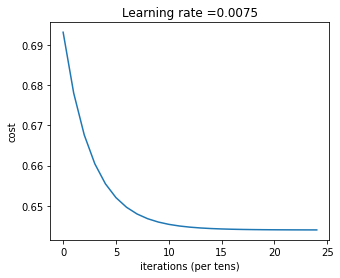

In [25]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model

parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations=2500, print_cost=True)

In [26]:
def predict(X,y,parameters):
    m = X.shape[1]
    L = len(parameters)//2
    output = np.zeros((1,m),dtype=int)
    
    a, caches = L_model_forward(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, a.shape[1]):
        if a[0,i] > 0.5:
            output[0,i] = 1
        else:
            output[0,i] = 0
    
    print("Accuracy: %s" % str(np.sum(output == y)/float(m)))
            
    return output

In [27]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.6555023923444976


In [28]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.34


Accuracy: 0.0
y = 0, your L-layer model predicts a "non-cat" picture.


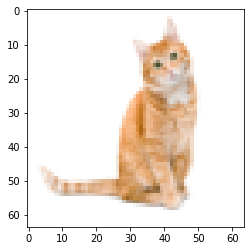

In [29]:
## START CODE HERE ##
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

my_image = "catmaybe.jpg"  # 이미지 파일 이름
my_label_y = [1]  # 정답 레이블 (1: 고양이, 0: 비고양이)
num_px = 64  # 이미지 크기 설정 (예: 64x64 픽셀)

# 이미지 로드 및 크기 조정
fname = "images/" + my_image
image = Image.open(fname)
image = image.resize((num_px, num_px))  # ✅ scipy.misc.imresize 대신 PIL.Image.resize 사용

# 이미지를 (num_px*num_px*3, 1) 형태로 변환
image_array = np.array(image).reshape((num_px*num_px*3, 1)) / 255.  # 0~1 정규화

# 예측 실행 (predict 함수가 정의되어 있어야 함)
my_predicted_image = predict(image_array, my_label_y, parameters)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + 
      ", your L-layer model predicts a \"" + 
      classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") + "\" picture.")